In [1]:
import matplotlib.pyplot as plt
import glob
from pyrex import core
from pyrex import tools
import numpy as np

In [2]:
data_path = "/Users/yesety/Documents/AEI/projects/eccentric/catalog_ecc/"
name2=['SXS_BBH_0184','SXS_BBH_1364','SXS_BBH_1365','SXS_BBH_1366','SXS_BBH_1367','SXS_BBH_1368','SXS_BBH_1369']
e_comm2=[0,0.044,0.06,0.095,0.096,0.097,0.185] #Hinder Phys Rev D 98 2018
t_peak2=[3014.6,3200.3,3180.7,3073.2,2955.2,2850.,2616.4]

#train and test data
train_e_comm2=[e_comm2[0],e_comm2[1],e_comm2[5],e_comm2[6]]
train_name2=[name2[0],name2[1],name2[5],name2[6]]
train_peak2=[t_peak2[0],t_peak2[1],t_peak2[5],t_peak2[6]]

test_e_comm2=[e_comm2[2],e_comm2[3],e_comm2[4]]
test_name2=[name2[2],name2[3],name2[4]]
test_peak2=[t_peak2[2],t_peak2[3],t_peak2[4]]

In [3]:
train_q2=core.Glassware(q=2,chi=0,data_path=data_path,names=train_name2)
test_q2=core.Glassware(q=2,chi=0,data_path=data_path,names=test_name2)
#q3=core.Glassware(q=3,chi=0)

# Waveform components

Text(0.5, 1.0, '$\\omega$')

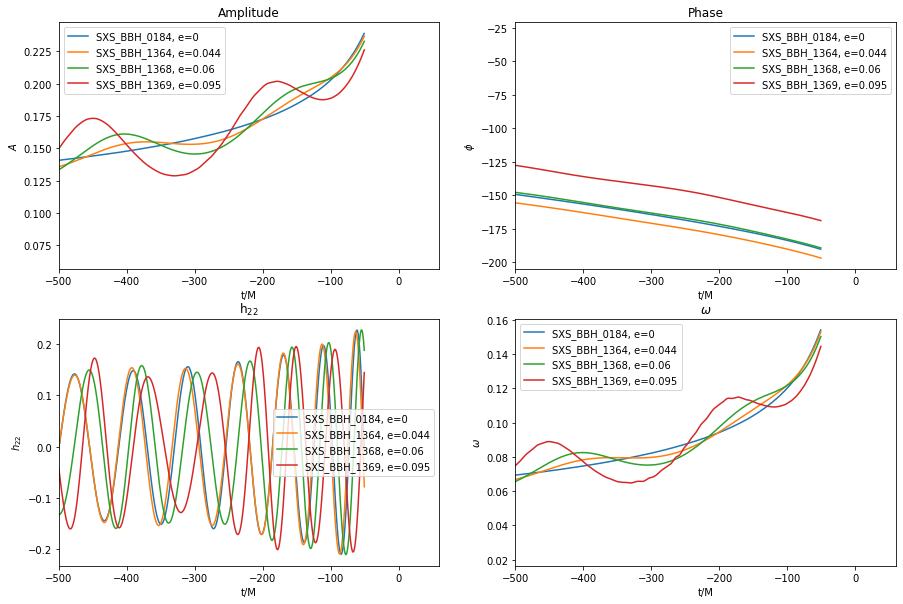

In [4]:
train_q2.components(train_peak2)

f, axs = plt.subplots(1,2,figsize=(15,10))
plt.subplot(221)
for i in range(len(train_e_comm2)):
    plt.plot(train_q2.time[i],train_q2.amp[i],label=train_q2.names[i]+str(', e=')+str(e_comm2[i]))
    plt.xlabel('t/M')
    plt.ylabel('$A$')
plt.xlim(-500,60)
plt.legend()
plt.title('Amplitude')

plt.subplot(222)
for i in range(len(train_e_comm2)):
    plt.plot(train_q2.time[i],train_q2.phase[i],label=train_q2.names[i]+str(', e=')+str(e_comm2[i]))
    plt.xlabel('t/M')
    plt.ylabel('$\phi$')
plt.xlim(-500,60)
plt.legend()
plt.title('Phase')

plt.subplot(223)
for i in range(len(train_e_comm2)):
    plt.plot(train_q2.time[i],train_q2.h22[i],label=train_q2.names[i]+str(', e=')+str(e_comm2[i]))
    plt.xlabel('t/M')
    plt.ylabel('$h_{22}$')
plt.xlim(-500,60)
plt.legend()
plt.title('h$_{22}$')

plt.subplot(224)
for i in range(len(train_e_comm2)):
    plt.plot(train_q2.time[i],train_q2.omega[i],label=train_q2.names[i]+str(', e=')+str(e_comm2[i]))
    plt.xlabel('t/M')
    plt.ylabel('$\omega$')
plt.xlim(-500,60)
plt.legend()
plt.title('$\omega$')

(-3000, 60)

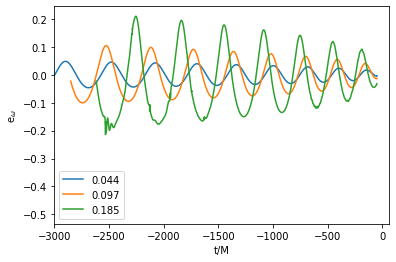

In [5]:
train_q2.compute_e_from_omega()
for i in range(len(train_name2)):
    if i>0:
        plt.plot(train_q2.time[i],train_q2.e_omega[i],label=train_e_comm2[i])
        plt.xlabel('t/M')
        plt.ylabel('e$_\omega$')
        plt.legend()
plt.xlim(-3000,60)

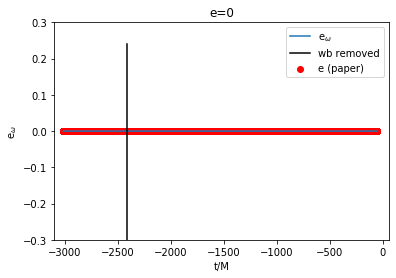

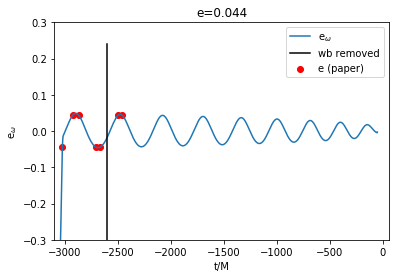

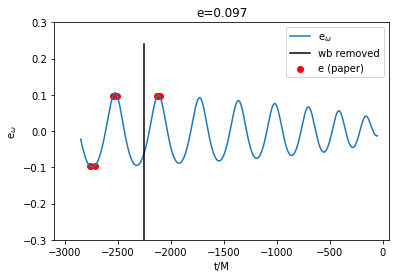

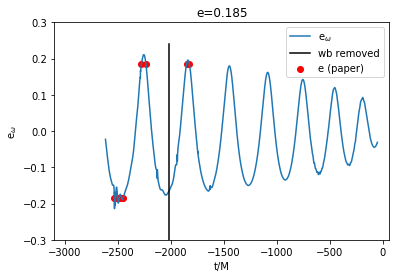

In [6]:
for i in range(len(train_name2)):    
    roots_pos,roots_neg=tools.find_intercept(train_q2.time[i],train_q2.e_omega[i],train_e_comm2[i])
    plt.plot(train_q2.time[i],train_q2.e_omega[i],label='e$_\omega$')
    plt.scatter(roots_pos,np.zeros(len(roots_pos))+train_e_comm2[i],color='r',label='e (paper)')
    plt.scatter(roots_neg,np.zeros(len(roots_neg))-train_e_comm2[i],color='r')
    plt.axvline(x=train_q2.time[i][0]+600,ymin=-0.7,ymax=0.9,color='k',label='wb removed')
    plt.xlabel('t/M')
    plt.ylabel('e$_\omega$')
    plt.title('e='+str(train_e_comm2[i]))
    plt.legend()
    plt.xlim(-3100,60)
    plt.ylim(-0.3,0.3)
    plt.show()

# Eccentricity from $\omega$

In [7]:
i=0
omega_lim=[]
e_omega_lim=[]
time_lim=[]
e_measured=[]
while (i<len(train_name2)):
    time_cut=train_q2.time[i][0]+600    
    time_lim.append(tools.time_window_greater(train_q2.time[i],time_cut,train_q2.time[i]))
    omega_lim.append(tools.time_window_greater(train_q2.time[i],time_cut,train_q2.omega[i]))
    e_omega_lim.append(tools.time_window_greater(train_q2.time[i],time_cut,train_q2.e_omega[i]))
    first_local_max=tools.find_locals(e_omega_lim[i],local_min=False,sfilter=True)[0]
    e_measured.append(e_omega_lim[i][first_local_max])
    print(str("e_omega="),round(e_measured[i],3),str(", error=")+str(round(np.abs(e_measured[i]-train_e_comm2[i])/(train_e_comm2[i])*100,3))+str('%'))
    i=i+1
    

e_omega= 0.0 , error=inf%
e_omega= 0.046 , error=4.899%
e_omega= 0.099 , error=2.202%
e_omega= 0.196 , error=5.923%


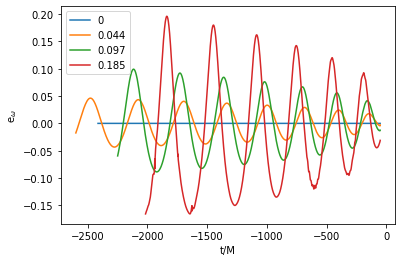

In [8]:
for i in range(len(train_name2)):
    plt.plot(time_lim[i],e_omega_lim[i],label=train_e_comm2[i])
plt.xlabel('t/M')
plt.ylabel('e$_\omega$')
plt.legend()

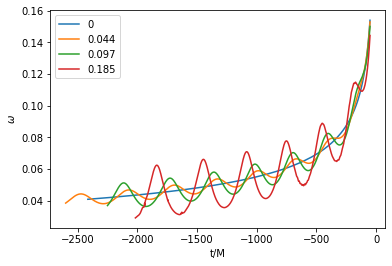

In [9]:
for i in range(len(train_name2)):
    plt.plot(time_lim[i],omega_lim[i],label=train_e_comm2[i])
plt.xlabel('t/M')
plt.ylabel('$\omega$')
plt.legend()

# Reverse the result

In [10]:
reverse=[]
for i in range(len(train_name2)):
    interp_c_omega=tools.interp_omega(time_lim[0],time_lim[i],omega_lim[0])
    reverse.append(e_omega_lim[i]*2*interp_c_omega+interp_c_omega)

Text(0.5, 1.0, 'e=0.185')

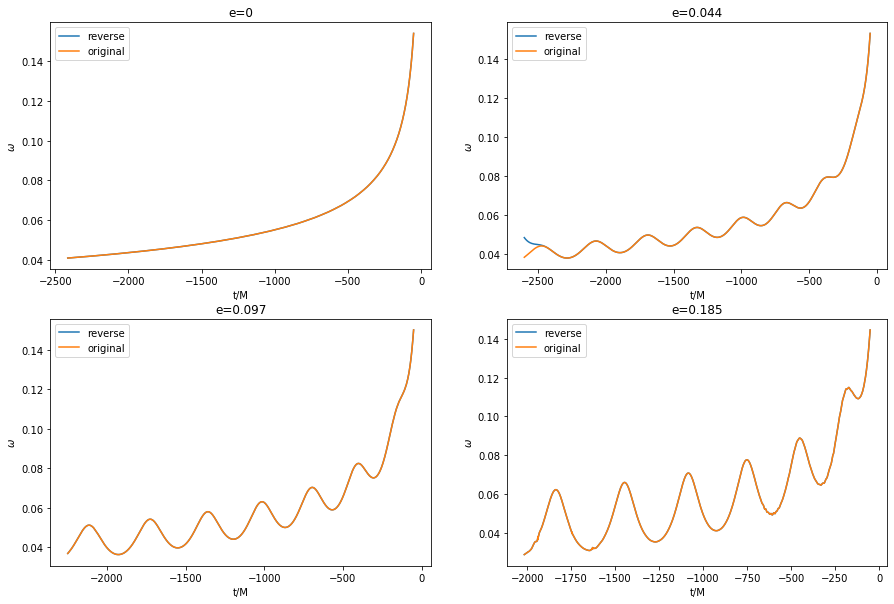

In [11]:
f, axs = plt.subplots(figsize=(15,10))

plt.subplot(221)
plt.plot(time_lim[0],reverse[0],label='reverse')
plt.plot(time_lim[0],omega_lim[0],label='original')
plt.xlabel('t/M')
plt.ylabel('$\omega$')
plt.legend()
plt.title('e='+str(train_e_comm2[0]))

plt.subplot(222)
plt.plot(time_lim[1],reverse[1],label='reverse')
plt.plot(time_lim[1],omega_lim[1],label='original')
plt.legend()
plt.xlabel('t/M')
plt.ylabel('$\omega$')
plt.title('e='+str(train_e_comm2[1]))

plt.subplot(223)
plt.plot(time_lim[2],reverse[2],label='reverse')
plt.plot(time_lim[2],omega_lim[2],label='original')
plt.legend()
plt.xlabel('t/M')
plt.ylabel('$\omega$')
plt.title('e='+str(train_e_comm2[2]))

plt.subplot(224)
plt.plot(time_lim[3],reverse[3],label='reverse')
plt.plot(time_lim[3],omega_lim[3],label='original')
plt.legend()
plt.xlabel('t/M')
plt.ylabel('$\omega$')
plt.title('e='+str(train_e_comm2[3]))
